# <center> **Movie Review Classification - Transformer Encoder**</center>
<center>
    <img src = "https://repository-images.githubusercontent.com/399420811/c477ff5c-8d89-4f48-a038-3ef7d9f25e72">
         </img>
</center
    

### Installing Dependencies unavailable in the environment

In [1]:
! pip install contractions
! python -m nltk.downloader all

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[

### Import Necessary Packages

In [2]:
import os
from google.colab import files, drive
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam

import nltk
from collections import Counter
import contractions
import re
from nltk import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.layers import StringLookup, TextVectorization
from tensorflow.keras.preprocessing.sequence import pad_sequences


### Setting Up Environment to get Google Drive Dataset in Colab

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Set Constants to Maintain Consistensy over the notebook

In [4]:
np.random.RandomState(7)

title_fd = {
    'fontsize': 20,
    'font':'SERIF'
}
label_fd = {
    'fontsize': 10,
    'font': 'SERIF'
}

stopwords_ = stopwords.words('english')
print(stopwords_)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [5]:
# We create a custom list of stopwords
# We choose to keep words like not or other negating words, that might have important meaning to out text.
stopwords_ = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",
              "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself',
              'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them',
              'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll",
              'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had',
              'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or',
              'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against',
              'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from',
              'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once',
              'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
              'most', 'other', 'some', 'such']
stopwords_pattern = re.compile(r'\b(' + r'|'.join(stopwords_) + r')\b\s*')

### Loading And Preprocessing Dataset

In [6]:
dir_path = '/content/drive/My Drive/Machine Learning Datasets/Movie Reviews Classification'

In [7]:
df = pd.read_csv(dir_path + ('/IMDB Dataset.csv'))
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [9]:
df.describe(include = 'all')

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


Text(0.5, 1.0, 'Distribution of Sentiments in dataset')

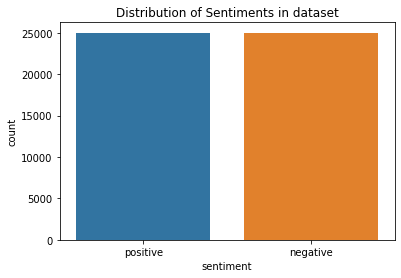

In [10]:
sns.countplot(data = df, x = 'sentiment')
plt.title('Distribution of Sentiments in dataset')

In [11]:
df = df.sample(frac = 1, random_state = 7)

In [12]:
train = df.iloc[:40000, :]
test = df.iloc[40000:]
train.to_csv((dir_path + '/train.csv'))
test.to_csv((dir_path + '/test.csv'))

In [13]:
lemmatizer = WordNetLemmatizer()

In [14]:
def preprocess_text(review):
    if isinstance(review, str):
        review = review.lower()
        review = contractions.fix(review)
        review = re.sub(r'<br />|\(|\)\{\}\[\]', " ", review)
        review = re.sub(r'[^A-Za-z]+',' ', review)
        review = nltk.word_tokenize(review)
        review = [lemmatizer.lemmatize(word) for word in review if word not in stopwords_]
        review = " ".join(review)
    return review

In [15]:
train.review.iloc[0]

'I love most movies and I\'m a big fan of Sean Bean so I thought that I would at least LIKE this movie. Also, I\'m Canadian and this is a mostly-Canadian movie so I was prepared to cut it some serious slack. Nothing could have prepared me for the garbage that is "Airborne". Steve Guttenberg as an action hero? Give me a break. The acting throughout the movie was so bad I am going to have trouble sleeping tonight. I now have only two wishes in my life.<br /><br />1. I hope that you never have to sit through this movie. 2. I wish I could get those 6 hours back. Oh wait, the movie\'s under 2 hours - it only seemed like 6 hours...<br /><br />Don\'t watch this. Seriously.'

In [16]:
train.iloc[:, 0] = train.iloc[:, 0].apply(preprocess_text)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


In [17]:
(train.review.iloc[0])


'love movie big fan sean bean so thought would least like movie also canadian mostly canadian movie so prepared cut serious slack nothing could prepared garbage airborne steve guttenberg action hero give break acting throughout movie so bad going trouble sleeping tonight now only two wish life hope never sit movie wish could get hour back oh wait movie s hour only seemed like hour not watch seriously'

## Convert Reviews into Vectors

In [18]:
def get_text_vectorizer(text_ds):
    text_vectorizer = TextVectorization()
    text_vectorizer.adapt(text_ds)
    vocab = text_vectorizer.get_vocabulary()
    word_index = dict(zip(vocab, range(len(vocab))))
    print("Total Number of Unique words in the text -", len(vocab))
    return vocab, word_index, text_vectorizer

In [19]:
vocab, word_index, text_vectorizer = get_text_vectorizer(train.review)

Total Number of Unique words in the text - 81655


In [20]:
vocab[:10]

['', '[UNK]', 'not', 'movie', 'film', 's', 'one', 'like', 'so', 'just']

In [21]:
vectorized_text = text_vectorizer(train.review)

In [22]:
print(vectorized_text.shape)
print("Max number of non-stop words in a review -", vectorized_text.shape[1])
print("Total Number of reviews - ", vectorized_text.shape[0])

(40000, 1472)
Max number of non-stop words in a review - 1472
Total Number of reviews -  40000


In [23]:
print(vectorized_text[0].numpy())

[ 45   3 115 ...   0   0   0]


In [24]:
print(vocab[:10])

['', '[UNK]', 'not', 'movie', 'film', 's', 'one', 'like', 'so', 'just']


In [25]:
# Word Index and vocabulary are basically inverse of each other
print(word_index['film'])

4


In [26]:
text__ = "My name is Aryan, and I am a Machine Learning enthusiast"
text__ = preprocess_text(text__)
text_vectorizer(text__)

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([  230, 13829,  1127,  2641,  5987])>

    -> We can observe above, that the stopwords like ["my", "is", "and", "i", "am"..] are removed, and the vectorized text contains a list of integer indices
    

## Loading pre-trained Glove Embeddings

In [27]:
# Download the pretrained Glove Embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2022-07-16 13:48:14--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-07-16 13:48:14--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-07-16 13:48:14--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [28]:
# First, we see the format in which embedding vectors are present in the files
with open('./glove.6B.50d.txt', "r") as f:
    count = 0
    for line in f:
        if(count == 3):
            break
        print(line)
        print('\n')
        count += 1
    f.close()

the 0.418 0.24968 -0.41242 0.1217 0.34527 -0.044457 -0.49688 -0.17862 -0.00066023 -0.6566 0.27843 -0.14767 -0.55677 0.14658 -0.0095095 0.011658 0.10204 -0.12792 -0.8443 -0.12181 -0.016801 -0.33279 -0.1552 -0.23131 -0.19181 -1.8823 -0.76746 0.099051 -0.42125 -0.19526 4.0071 -0.18594 -0.52287 -0.31681 0.00059213 0.0074449 0.17778 -0.15897 0.012041 -0.054223 -0.29871 -0.15749 -0.34758 -0.045637 -0.44251 0.18785 0.0027849 -0.18411 -0.11514 -0.78581



, 0.013441 0.23682 -0.16899 0.40951 0.63812 0.47709 -0.42852 -0.55641 -0.364 -0.23938 0.13001 -0.063734 -0.39575 -0.48162 0.23291 0.090201 -0.13324 0.078639 -0.41634 -0.15428 0.10068 0.48891 0.31226 -0.1252 -0.037512 -1.5179 0.12612 -0.02442 -0.042961 -0.28351 3.5416 -0.11956 -0.014533 -0.1499 0.21864 -0.33412 -0.13872 0.31806 0.70358 0.44858 -0.080262 0.63003 0.32111 -0.46765 0.22786 0.36034 -0.37818 -0.56657 0.044691 0.30392



. 0.15164 0.30177 -0.16763 0.17684 0.31719 0.33973 -0.43478 -0.31086 -0.44999 -0.29486 0.16608 0.11963 -0.41328 -0

In [29]:
def get_glove_emb_vectors(filepath):
    word_to_idx = {}
    idx_to_word = {}
    word_to_vec_map = {}
    
    with open(filepath, "r") as f:
        for idx, line in enumerate(f):
            word, vec = line.split(' ', maxsplit = 1)
            vec = np.fromstring(vec, dtype = np.float32, sep = " ")
            idx_to_word[idx] = word
            word_to_idx[word] = idx
            word_to_vec_map[word] = vec
    return word_to_idx, idx_to_word, word_to_vec_map

In [30]:
embedding_dims = 300
filepath = f'./glove.6B.{embedding_dims}d.txt'
word_to_idx, idx_to_word, word_to_vec = get_glove_emb_vectors(filepath)
print(f"Found {len(word_to_idx)} word vectors.")

Found 400000 word vectors.


In [31]:
# Let's look at the emb vector of a word
print(word_to_vec["hello"])

[-3.3712e-01 -2.1691e-01 -6.6365e-03 -4.1625e-01 -1.2555e+00 -2.8466e-02
 -7.2195e-01 -5.2887e-01  7.2085e-03  3.1997e-01  2.9425e-02 -1.3236e-02
  4.3511e-01  2.5716e-01  3.8995e-01 -1.1968e-01  1.5035e-01  4.4762e-01
  2.8407e-01  4.9339e-01  6.2826e-01  2.2888e-01 -4.0385e-01  2.7364e-02
  7.3679e-03  1.3995e-01  2.3346e-01  6.8122e-02  4.8422e-01 -1.9578e-02
 -5.4751e-01 -5.4983e-01 -3.4091e-02  8.0017e-03 -4.3065e-01 -1.8969e-02
 -8.5670e-02 -8.1123e-01 -2.1080e-01  3.7784e-01 -3.5046e-01  1.3684e-01
 -5.5661e-01  1.6835e-01 -2.2952e-01 -1.6184e-01  6.7345e-01 -4.6597e-01
 -3.1834e-02 -2.6037e-01 -1.7797e-01  1.9436e-02  1.0727e-01  6.6534e-01
 -3.4836e-01  4.7833e-02  1.6440e-01  1.4088e-01  1.9204e-01 -3.5009e-01
  2.6236e-01  1.7626e-01 -3.1367e-01  1.1709e-01  2.0378e-01  6.1775e-01
  4.9075e-01 -7.5210e-02 -1.1815e-01  1.8685e-01  4.0679e-01  2.8319e-01
 -1.6290e-01  3.8388e-02  4.3794e-01  8.8224e-02  5.9046e-01 -5.3515e-02
  3.8819e-02  1.8202e-01 -2.7599e-01  3.9474e-01 -2

In [32]:
# Now, we shall create the Embedding Matrix for our vocabulary

def get_embedding_matrix(word_index, word_to_vector):
    # Number of tokens in emb matrix is taken to be 2 more than vocab size
    hits, misses = 0, 0
    num_tokens = len(word_index) + 2
    
    # Use a common word expected to be in any embedding vector dictionary to get emb shape 
    emb_dims = word_to_vector['hello'].shape[0]
    
    # Initialize the embedding matrix with zeros
    embedding_matrix = np.zeros((num_tokens, emb_dims), dtype = np.float32)
    
    for word, idx in word_index.items():
        emb_vector = word_to_vector.get(word)
        if emb_vector is not None:
            embedding_matrix[idx] = emb_vector
            hits+= 1
        else:
            misses += 1
    print(f"For the {hits+misses} words in the vocabulary for given text,\n",
            f"{hits} words were found in the glove embeddings, while {misses} words could not be found")
    return embedding_matrix

In [33]:
EMBEDDING_MATRIX = get_embedding_matrix(word_index, word_to_vec)

For the 81655 words in the vocabulary for given text,
 61114 words were found in the glove embeddings, while 20541 words could not be found


In [34]:
EMBEDDING_MATRIX.shape

(81657, 300)

In [35]:
with open((dir_path + "/Embedding_Matrix_300.npy"), "wb") as f:
    np.save(f, EMBEDDING_MATRIX)
    f.close()

### Data Preparation

In [36]:
BATCH_SIZE = 128
MAX_SEQ_LEN = 1500
EMB_DIMS = 300
VOCAB_SIZE = EMBEDDING_MATRIX.shape[0]

In [37]:
def DataPipeline(df, text_vectorizer, truncating = 'post'):
    X_data = df.review.apply(preprocess_text)
    X_data = text_vectorizer(X_data)
    X_data = pad_sequences(X_data, maxlen = MAX_SEQ_LEN, truncating = truncating)
    Y_data = df.sentiment
    Y_data = df.sentiment.apply(lambda x: 1 if(x == 'positive') else 0)
    return X_data, Y_data

In [38]:
data = pd.read_csv(dir_path + '/IMDB Dataset.csv')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [39]:
data.drop_duplicates(inplace = True)

In [40]:
data = data.sample(frac = 1, random_state = 7)
print(len(data))

49582


In [41]:
train = data[:40000]
test = data[40000:]

In [42]:
del(data)

In [43]:
train.head()

,review,sentiment
20275,I think that this is a disappointing sequel. I...,negative
19851,"Uhhh ... so, did they even have writers for th...",negative
6957,Critics are falling over themselves within the...,negative
30980,"This movie was very funny, I couldn't stop smi...",positive
40220,Happened upon a copy of this. Not mine and if ...,negative


In [44]:
len(train)

40000

In [45]:
X_train, Y_train = DataPipeline(train, text_vectorizer, truncating = 'post')
X_test, Y_test = DataPipeline(test, text_vectorizer,  truncating = 'post')

In [46]:
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(40000, 1500) (40000,)
(9582, 1500) (9582,)


In [47]:
Y_train = Y_train[:, np.newaxis]
Y_test = Y_test[:, np.newaxis]
Y_train.shape, Y_test.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


((40000, 1), (9582, 1))

In [49]:
with open(dir_path + "/X_train.npy", "wb") as f:
    np.save(f, X_train)
    f.close()

with open(dir_path + "/X_test.npy", "wb") as f:
    np.save(f, X_test)
    f.close()


with open(dir_path + "/Y_train.npy", "wb") as f:
    np.save(f, Y_train)
    f.close()

with open(dir_path + "/Y_test.npy", "wb") as f:
    np.save(f, Y_test)
    f.close()

<center> **a----------END-----------a** </center>